# Graph Neural Networks

In [206]:
import networkx as nx
import scipy.sparse as sparse
import numpy as np
import matplotlib
import pandas as pd
from matplotlib.colors import ListedColormap
import tensorflow as tf
import matplotlib.pyplot

In [207]:
graph = nx.read_gexf('grafo_ultimo.gexf', node_type=None, relabel=False)
adj_matrix = nx.adjacency_matrix(graph)

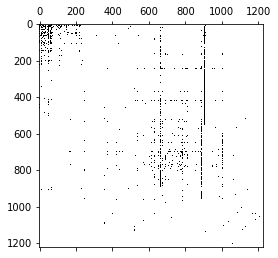

In [208]:
cmap = ListedColormap(['white', 'black'])
matplotlib.pyplot.matshow(adj_matrix, cmap=cmap)

# Mergeo información de mis 2 datasets, el que contiene la red y el que contiene información de perfiles

In [209]:
dataset = pd.read_csv("perfiles_etiquetados.csv")
users = pd.read_csv("users_info.csv")
dataset.rename(columns={'Label':'screen_name'}, inplace=True)
full_dataset = pd.merge(dataset,users,on='screen_name',how='left')

# Transformo el dataset cambiando las clases por 0 (FA) y 1 (CM). Las demás clases (periodista, medio, etc) las pongo en NaN.

In [210]:
full_dataset = full_dataset.replace({'medio': np.nan })
full_dataset = full_dataset.replace({'periodista': np.nan })
full_dataset = full_dataset.replace({'institucional': np.nan })
full_dataset = full_dataset.replace({'fa': 0 })
full_dataset = full_dataset.replace({'cm': 1 })

In [211]:
full_dataset.head(6)

,Id,screen_name,timeset,afinidad,modularity_class,pageranks,indegree,outdegree,Degree,Eccentricity,...,eigencentrality,id_str,location,description,protected,verified,followers_count,friends_count,statuses_count,created_at
0,1052916459834364032,MillorLujan,NaN,NaN,5,0.000266,7,13,20,7,...,0.069047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1192212972497784832,MonicaBatlle4,NaN,NaN,3,0.002817,142,205,347,6,...,0.482481,1.192213e+18,"Montevideo, Uruguay",Medica Diabetologa Tricolor a muerte,False,False,4557.0,4126.0,18797.0,2019-11-06 22:51:51
2,427830008,ubidominans,NaN,NaN,5,0.002089,84,37,121,6,...,0.483722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1367991289,laresistencia72,NaN,NaN,5,0.000727,29,54,83,6,...,0.235189,1.367991e+09,Uruguayo,''Que En Todos Lados Se Vea El Poder De La Cla...,False,False,383.0,839.0,2067.0,2013-04-20 20:51:14
4,938192801023561600,Sofamansillaeco,NaN,NaN,5,0.000272,6,9,15,7,...,0.055201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1045117028733001600,Mabel546,NaN,0.0,5,0.001398,64,73,137,6,...,0.480269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Remuevo columnas que no voy a utilizar y guardo las etiquetas en la variable `labels`

In [212]:
ids = full_dataset['Id']
labels = full_dataset['afinidad']
full_dataset = full_dataset.drop(columns=['afinidad', 'protected', 'verified', 'location', 'description', 'Id', 'screen_name', 'timeset', 'modularity_class', 'componentnumber', 'strongcompnum', 'indegree', 'outdegree', 'Degree', 'Eccentricity', 'id_str', 'created_at'])

In [213]:
full_dataset

,pageranks,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,Authority,Hub,clustering,eigencentrality,followers_count,friends_count,statuses_count
0,0.000266,0.320755,0.355198,0.000001,0.005914,0.013885,0.620879,0.069047,NaN,NaN,NaN
1,0.002817,0.410276,0.508049,0.028870,0.119300,0.137382,0.136201,0.482481,4557.0,4126.0,18797.0
2,0.002089,0.344670,0.386591,0.004461,0.042358,0.022055,0.285014,0.483722,NaN,NaN,NaN
3,0.000727,0.361454,0.410073,0.002988,0.019821,0.033001,0.470999,0.235189,383.0,839.0,2067.0
4,0.000272,0.313411,0.344271,0.000093,0.004358,0.008175,0.344444,0.055201,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1219,0.000630,0.666667,0.750000,0.000000,0.000000,0.000000,0.000000,0.000063,175.0,265.0,4091.0
1220,0.000215,0.210674,0.219191,0.001612,0.000052,0.000000,0.000000,0.000083,272.0,515.0,5520.0
1221,0.001192,1.000000,1.000000,0.000001,0.000000,0.000000,0.000000,0.000115,NaN,NaN,NaN
1222,0.000294,0.213015,0.222589,0.000000,0.000010,0.000033,0.000000,0.000400,342.0,591.0,15381.0


# Sustituyo la información faltante por sus respectivas medias

In [214]:
full_dataset = full_dataset.fillna(full_dataset.mean())

# Obtengo índices que tienen etiquetas

In [215]:
index_of_labeled = labels[labels.notnull()].index
index_of_labeled

Int64Index([   5,   11,   12,   13,   14,   22,   23,   28,   29,   30,   34,
              37,   38,   39,   41,   42,   45,   50,   51,   53,   54,   55,
              56,   61,   62,   65,   68,   71,   72,   74,   89,  105,  112,
             113,  120,  154,  209,  219,  248,  443,  518,  519,  522,  525,
             529,  530,  544,  545,  547,  553,  569,  573,  601,  607,  612,
             622,  631,  640,  644,  648,  661,  662,  666,  676,  677,  685,
             695,  698,  764,  765,  780,  781,  793,  794,  795,  796,  805,
             862,  887,  910,  912,  914,  935,  946,  947,  952,  955,  961,
             967,  993, 1001, 1002],
           dtype='int64')

# Construyo matrix de etiquetas de 2xN con:  FA 0, CM 1, sin etiqueta: NaN

In [216]:
valid_labels_cm = labels.values
valid_labels_fa = 1 - valid_labels_cm
labels_matrix = [valid_labels_fa, valid_labels_cm]
labels_matrix = np.array(labels_matrix).transpose()
labels_matrix

array([[nan, nan],
       [nan, nan],
       [nan, nan],
       ...,
       [nan, nan],
       [nan, nan],
       [nan, nan]])

# Normalizamo la data

In [217]:
from sklearn import preprocessing

x = full_dataset.values # returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
scaled_labeled_dataset = pd.DataFrame(x_scaled)

scaled_matrix = scaled_labeled_dataset.to_numpy()

# Genero máscaras utilizando el arreglo de índices `index_of_nodes_with_info` y `labels` tomando índices aleatorios que contengan etiquetas

In [218]:
np_index = np.array(index_of_labeled)
np.random.shuffle(np_index)
train_indices = np_index[1:72] # 80% para train
test_indices = np_index[72:-1] # 20 % test y validación

# Una vez obtenidos los índices, genero las máscaras

In [219]:
training_mask = np.zeros((len(labels),),dtype=bool)
testing_mask = np.zeros((len(labels),),dtype=bool)
validating_mask = np.zeros((len(labels),),dtype=bool)

training_mask[train_indices] = True
testing_mask[test_indices] = True
validating_mask[test_indices] = True

# Imprimo formas de las entradas para verificar correctitud

In [220]:
adj_matrix.shape, scaled_matrix.shape, labels_matrix.shape

((1224, 1224), (1224, 11), (1224, 2))

In [221]:
training_mask.shape, testing_mask.shape, validating_mask.shape

((1224,), (1224,), (1224,))

In [223]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from spektral.layers import GraphConv

# Load data
A = adj_matrix
X = scaled_matrix
y = labels_matrix
train_mask = training_mask
val_mask = validating_mask
test_mask = testing_mask


# Parameters
channels = 16           # Number of channels in the first layer
N = X.shape[0]          # Number of nodes in the graph
F = X.shape[1]          # Original size of node features
n_classes = 2           # Number of classes
dropout = 0.01           # Dropout rate for the features
l2_reg = 5e-4 / 2       # L2 regularization rate
learning_rate = 1e-3    # Learning rate > => < epochs
epochs = 20             # Number of training epochs

# Preprocessing operations
fltr = GraphConv.preprocess(A).astype('f4')
#X = X.toarray()

# Model definition
X_in = Input(shape=(F, ))
fltr_in = Input((N, ), sparse=True)

dropout_1 = Dropout(dropout)(X_in)
graph_conv_1 = GraphConv(channels,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         use_bias=False)([dropout_1, fltr_in])
dropout_2 = Dropout(dropout)(graph_conv_1)
graph_conv_2 = GraphConv(n_classes,
                         activation='softmax',
                         use_bias=False)([dropout_2, fltr_in])

# Build model
model = Model(inputs=[X_in, fltr_in], outputs=graph_conv_2)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])
model.summary()

# Train model
validation_data = ([X, fltr], y, val_mask)
model.fit([X, fltr],
          y,
          sample_weight=train_mask,
          epochs=epochs,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False)

# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([X, fltr],
                              y,
                              sample_weight=test_mask,
                              batch_size=N)
print('Done.\n'
      'Test loss: {}\n'
      'Test accuracy: {}'.format(*eval_results))

Model: "functional_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           [(None, 11)]         0                                            
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 11)           0           input_39[0][0]                   
__________________________________________________________________________________________________
input_40 (InputLayer)           [(None, 1224)]       0                                            
__________________________________________________________________________________________________
graph_conv_36 (GraphConv)       (None, 16)           176         dropout_37[0][0]                 
                                                                 input_40[0][0]       

In [200]:
X.shape, fltr.shape

((1224, 11), (1224, 1224))